# Mask-RCNN Label Generation

## Notebook Setup 
The following cell will install Drake, checkout the manipulation repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  

More details are available [here](http://manipulation.mit.edu/drake.html).

In [1]:
import importlib
import os, sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='9334a842594b94b69b6ec59d7806e7618a19206d', drake_version='20201020', drake_build='nightly')

from IPython import get_ipython
running_as_notebook = get_ipython() and hasattr(get_ipython(), 'kernel')

# Setup rendering (with xvfb), if necessary:
import os
if 'google.colab' in sys.modules and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# setup ngrok server
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import numpy as np

from pydrake.all import ( 
    AddMultibodyPlantSceneGraph, ConnectMeshcatVisualizer, 
    DiagramBuilder, RigidTransform, RotationMatrix, Parser, Simulator,
    FindResourceOrThrow,Quaternion, AddTriad
)

import open3d as o3d
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

from manipulation.meshcat_utils import draw_open3d_point_cloud, draw_points
from manipulation.mustard_depth_camera_example import MustardExampleSystem
from manipulation.utils import FindResource
from manipulation.open3d_utils import create_open3d_point_cloud

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from copy import deepcopy
import pydot
from ipywidgets import Dropdown, Layout
from IPython.display import display, HTML, SVG

KeyboardInterrupt: ignored

In [ ]:
class SimpleCameraSystem:
    def __init__(self):
        diagram = MustardExampleSystem()
        context = diagram.CreateDefaultContext()
        
        # setup
        self.meshcat_vis = meshcat.Visualizer(zmq_url=zmq_url)
        self.meshcat_vis["/Background"].set_property("visible", False)
        
        # getting data
        self.point_cloud = diagram.GetOutputPort("camera0_point_cloud").Eval(context)
        self.depth_im_read = diagram.GetOutputPort('camera0_depth_image').Eval(context).data.squeeze()
        self.depth_im = deepcopy(self.depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        label_im = diagram.GetOutputPort('camera0_label_image').Eval(context).data.squeeze()
        self.rgb_im = diagram.GetOutputPort('camera0_rgb_image').Eval(context).data
        self.mask = label_im == 1

        # draw visualization
        pcd = create_open3d_point_cloud(self.point_cloud)
        draw_open3d_point_cloud(self.meshcat_vis["self.point_cloud"], pcd)
        
        # camera specs
        cam0 = diagram.GetSubsystemByName('camera0')
        cam0_context = cam0.GetMyMutableContextFromRoot(context)
        cam0_pose = cam0.GetOutputPort('X_WB').Eval(cam0_context)
        self.cam_info = cam0.depth_camera_info()
        self.X_WC = RigidTransform(quaternion=Quaternion(cam0_pose[3:]), p=cam0_pose[0:3])

        # get points for mustard bottle
        depth_mustard = self.mask * self.depth_im
        u_range = np.arange(depth_mustard.shape[0])
        v_range = np.arange(depth_mustard.shape[1])
        depth_v, depth_u = np.meshgrid(v_range, u_range)
        depth_pnts = np.dstack([depth_u, depth_v, depth_mustard])
        depth_pnts = depth_pnts.reshape([depth_pnts.shape[0]*depth_pnts.shape[1], 3])
        pC =self.project_depth_to_pC(depth_pnts)
        p_C_mustard = pC[pC[:,2] > 0]
        self.p_W_mustard = self.X_WC.multiply(p_C_mustard.T).T
    
    def get_color_image(self):
        return deepcopy(self.rgb_im[:,:,0:3])
    
    def get_intrinsics(self):
        # read camera intrinsics
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        return cx, cy, fx, fy
    def project_depth_to_pC(self, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:,0]
        u = depth_pixel[:,1]
        Z = depth_pixel[:,2]
        cx, cy, fx, fy = self.get_intrinsics()
        X = (u-cx) * Z/fx
        Y = (v-cy) * Z/fy
        pC = np.c_[X,Y,Z]
        return pC
    
def bbox(img):
    a = np.where(img != 0)
    bbox = ([np.min(a[0]), np.max(a[0])], [np.min(a[1]), np.max(a[1])])
    return bbox
        
env = SimpleCameraSystem()
X_WC = env.X_WC
p_W_mustard = env.p_W_mustard
K = env.cam_info.intrinsic_matrix()
rgb_im = env.get_color_image()

# Generate Mask Labels

In the lecture, you have learned about Mask-RCNN. A major difficulty in training/fine-tuning Mask-RCNN is to obtain high-quality real training data, especially the mask labels for the objects of interest. Although you can get training labels from [Amazon Mechanical Turk](https://www.mturk.com/), it is a paid service and you will have to wait for some time until you get your data labeled. An alternative method is to design clever pipelines to generate labeled masks automatically without requiring manual labor.  

Consider a setup where an object of interest is placed on a planar surface, and an RGBD camera is mounted at a fixed location pointing to the object. From the RGBD camera, you should be able to generate the corresponding point clouds of the desired object and the surrounding environment (e.g. planar surface). You can easily remove the points associated with the planar surface (recall RANSAC exercise in the problem set 2). The remaining points then should all belong to the desired object. To generate mask labels, all you need to do is to project the points back to the camera image plane using the pinhole camera model!

Let's quickly review the pinhole camera model!

In the last problem set, you have played with [pinhole camera model](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). In particular, you used the pinhole camera model to map the depth pixels to 3D points. You may review the `SimpleCameraSystem` class from the last problem set.

The mathematical description of the pinhole camera model is written below (you may also use the intrinsics matrix by `env.cam_info.intrinsic_matrix()`).

The camera intrinsics are:
\begin{equation}
X_c = (u-c_x)\frac{Z_c}{f_x}
\end{equation}

\begin{equation}
Y_c = (v-c_y)\frac{Z_c}{f_y}
\end{equation}

Notations:
- $f_x$: focal length in x direction
- $f_y$: focal length in y direction
- $c_x$: principal point in x direction (pixels)
- $c_y$: principal point in y direction (pixels)
- $(X_C, Y_C, Z_C)$: points in camera frame

where $f_x$, $f_y$, $c_x$, $c_y$ specify the intrinsics of the camera.

The diagram of the pinhole camera model below is found from [OpenCV documentation](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). Note that the $u$ and $v$ directions are reversed in Python due to the difference in the convention.

![](https://docs.opencv.org/3.4/pinhole_camera_model.png)

## Generate Mask from Point Clouds

Now given the points of the mustard bottle in the world frame p_W_mustard, can you re-project these points back to the image plane to construct the mask of the mustard bottle? Note that you may need to reverse u,v indices to get the mask of the mustard bottle upright. Your mask should be of the same size as the original depth image, which is (480, 640)

In [ ]:
def deproject_pW_to_image(p_W_mustard, cx, cy, fx, fy, X_WC):
    """
    convert points in the world frame to camera pixels
    Input:
        - p_W_mustard: points of the mustard bottle in world frame (nx3)
        - fx, fy, cx, cy: camera intrinsics
        - X_WC: camera pose in the world frame 
    Output:
        - mask: numpy array of size 480x640
    """
    X_CW = X_WC.inverse()
    p_C_mustard = X_CW.multiply(p_W_mustard.T).T
    X_C_mustard = p_C_mustard[:,0]
    Y_C_mustard = p_C_mustard[:,1]
    Z_C_mustard = p_C_mustard[:,2]

    u = (X_C_mustard * fx)/(Z_C_mustard) + cx
    v = (Y_C_mustard * fy)/(Z_C_mustard) + cy
    mask = np.zeros([480, 640])
    mask[v.astype(int),u.astype(int)] = 100
    return mask

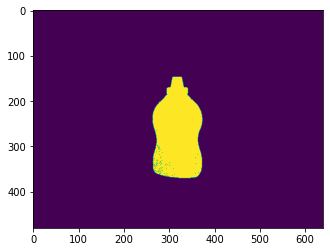

In [ ]:
cx, cy, fx, fy = env.get_intrinsics()
mask = deproject_pW_to_image(p_W_mustard, cx, cy, fx, fy, X_WC)
plt.imshow(mask)

You should be able to visually verify that the generated mask perfectly align with the mustard bottle!

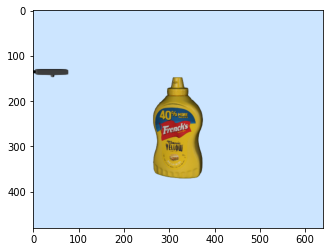

In [ ]:
plt.imshow(rgb_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


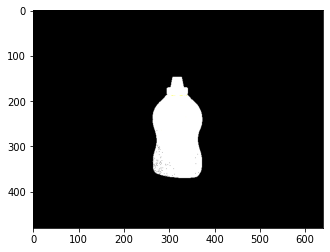

In [ ]:
masked_rgb = rgb_im * mask[:,:,np.newaxis].astype(int) 
plt.imshow(masked_rgb)

# Analysis for Cluttered Scenes
**Now you have a working pipeline for generating mask labels for single objects on a planar surface. Now consider besides a mustard bottle, you also have a Cheez-It box in the scene. Both objects appear in your RGBD image. Answer the following questions.**

**6.1.b** Assume the Cheez-It box is not occluding the mustard bottle, without any modification to the pipeline above, can you get the separate masks of the mustard bottle and Cheez-It box? Explain your reasoning.

**6.1.c** Assume the Cheez-It box is occluding the mustard bottle, without any modification to the pipeline above, can you get the separate masks of the mustard bottle and Cheez-It box? Explain your reasoning.

# Generate Training Images and Masks via Data Augmentation

[Data augmentation](https://en.wikipedia.org/wiki/Data_augmentation) is commonly used to generate more training data from the existing data. For example, a common trick to generate training images and masks for occluded scenes is to randomly insert rendered objects on top of the real image. Similarly, you can randomly scale, flip, rotate, duplicate, and crop to "simulate" more complex scenes.  

<figure>
<center>
<img src='https://developers.google.com/machine-learning/practica/image-classification/images/data_augmentation.png' />
<figcaption>Example Image Data Augmentation (credit: developers.google.com)</figcaption></center>
</figure>

In this exercise, we ask you to explore different ways to augment from our existing mustard bottle image:
- flipping
- translating
- duplication 
- cropping
- adding noise 

**Please complete the function below to generate 1 more pair of a color image and mask label using at least 2 tricks above to augment your data. You may use Numpy only!** 

**Note: make sure you display both of the your new image and mask below in your notebook submission. Your results will be visually graded**

In [ ]:
def augment_mustard_bottle(rgb_im, mask):
    """
    perform random rotation, scaling, and duplication to generate
    more training images and labels
    rgb_im: original rgb image of the mustard bottle
    mask: binay mask of the mustard bottle
    """
    # augmented_rgb = np.zeros((480, 640, 3))
    # augmented_mask = np.zeros((480, 640))

    x_shape, y_shape = mask.shape
    augmented_rgb = rgb_im.copy()
    augmented_mask = mask.copy()

    # flipping left-right
    augmented_rgb = np.fliplr(augmented_rgb)
    augmented_mask = np.fliplr(augmented_mask)

    # add gaussian noise
    mu = 20; sigma = 10
    augmented_rgb = augmented_rgb + np.random.normal(mu, sigma, rgb_im.shape)
    augmented_rgb = np.clip(0,255, augmented_rgb.astype(int))   # make sure that pixel values do not go beyond [0,255] range

    # add salt-pepper noise
    num_salt = 10000; num_pepper = 10000
    salt_coords   = [np.random.randint(0, i - 1, int(num_salt)) for i in mask.shape]
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in mask.shape]
    augmented_rgb[salt_coords[0],salt_coords[1]] = 255
    augmented_rgb[pepper_coords[0],pepper_coords[1]] = 0

    # translate in x
    x_shift = 100
    augmented_rgb = np.roll(augmented_rgb, x_shift, axis=1)
    augmented_mask = np.roll(augmented_mask, x_shift, axis=1)

    # translate in y
    y_shift = 100
    augmented_rgb = np.roll(augmented_rgb, y_shift, axis=0)
    augmented_mask = np.roll(augmented_mask, y_shift, axis=0)
    # NOTE @nsidn98: assuming wrapping when shifting is carried out is good
    # have to take care of situations where half of the object is one the left
    # and the other half is on the right
    # this situation is highly unlikely as only small shifts would be used in
    # the augmentation process

    return augmented_rgb, augmented_mask

In [ ]:
new_img, new_mask = augment_mustard_bottle(rgb_im, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


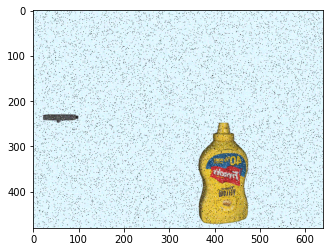

In [ ]:
plt.imshow(new_img)

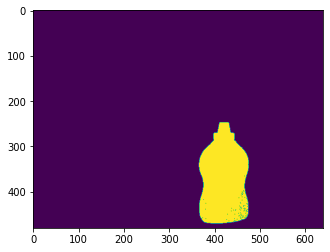

In [ ]:
plt.imshow(new_mask)

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `label_generation.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Write down your answers to 6.1.b and 6.1.c to a separately pdf file and submit it to Gradescope's written submission section. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [3 pts] Correct Implementation of `deproject_pW_to_image` method.
- [2 pts] Analysis for Cluttered Scenes: reasonable answers and explanations. 
- [2 pts] Visually reasonable output from `augment_mustard_bottle`.


In [ ]:
from manipulation.exercises.segmentation.test_mask import TestMask
from manipulation.exercises.grader import Grader 

Grader.grade_output([TestMask], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 3/3.

Score for Testing deproject_pW_to_image is 3/3.
